In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

In [2]:
df = pd.read_csv('MHpredict.csv')
data = df.copy()
for col in data:
    if data[col].dtype not in ['int64', 'float64']:
        print(f'{col}: {data[col].unique()}')

disType: ['anxiety disorder' 'comorbid disorder' 'depressive disorder']
Sexe: ['male' 'female']
pedigree: ['Yes' 'No']
alcohol: ['No positive alcohol diagnose'
 'Diagnose alcohol dependent or alcohol abuse']
bTypeDep: ['No depressive disorder' 'Recurrent MDD' 'First onset MDD' 'Dysthymia']
bSocPhob: ['Positive' 'Negative']
bGAD: ['Positive' 'Negative']
bPanic: ['Negative' 'Positive']
bAgo: ['Negative' 'Positive']
RemDis: [ True False]
sample: ['Specialised mental health care' 'Primary care' 'General population']
ADuse: [False  True]
PsychTreat: [ True False]


Convert our categorical variables to factor type:

In [3]:
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)
cat_cols = data.select_dtypes(include='O').columns.tolist()
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

In [4]:
data.head()

,Age,aedu,IDS,BAI,FQ,LCImax,AO,RemDis,ADuse,PsychTreat,...,alcohol_No positive alcohol diagnose,bTypeDep_First onset MDD,bTypeDep_No depressive disorder,bTypeDep_Recurrent MDD,bSocPhob_Positive,bGAD_Positive,bPanic_Positive,bAgo_Positive,sample_Primary care,sample_Specialised mental health care
0,53,9,4,6,0,0.400000,21,1,0,1,...,True,False,True,False,True,True,False,False,False,True
1,25,15,12,14,14,0.518519,14,0,1,1,...,False,False,False,True,False,False,True,False,False,True
2,41,9,15,13,0,0.610169,15,0,1,1,...,True,False,False,True,False,True,False,False,False,True
3,56,6,9,12,6,0.672727,21,0,0,1,...,True,True,False,False,False,False,False,False,True,False
4,64,10,15,22,16,1.000000,54,0,1,0,...,True,False,False,True,True,False,False,True,True,False


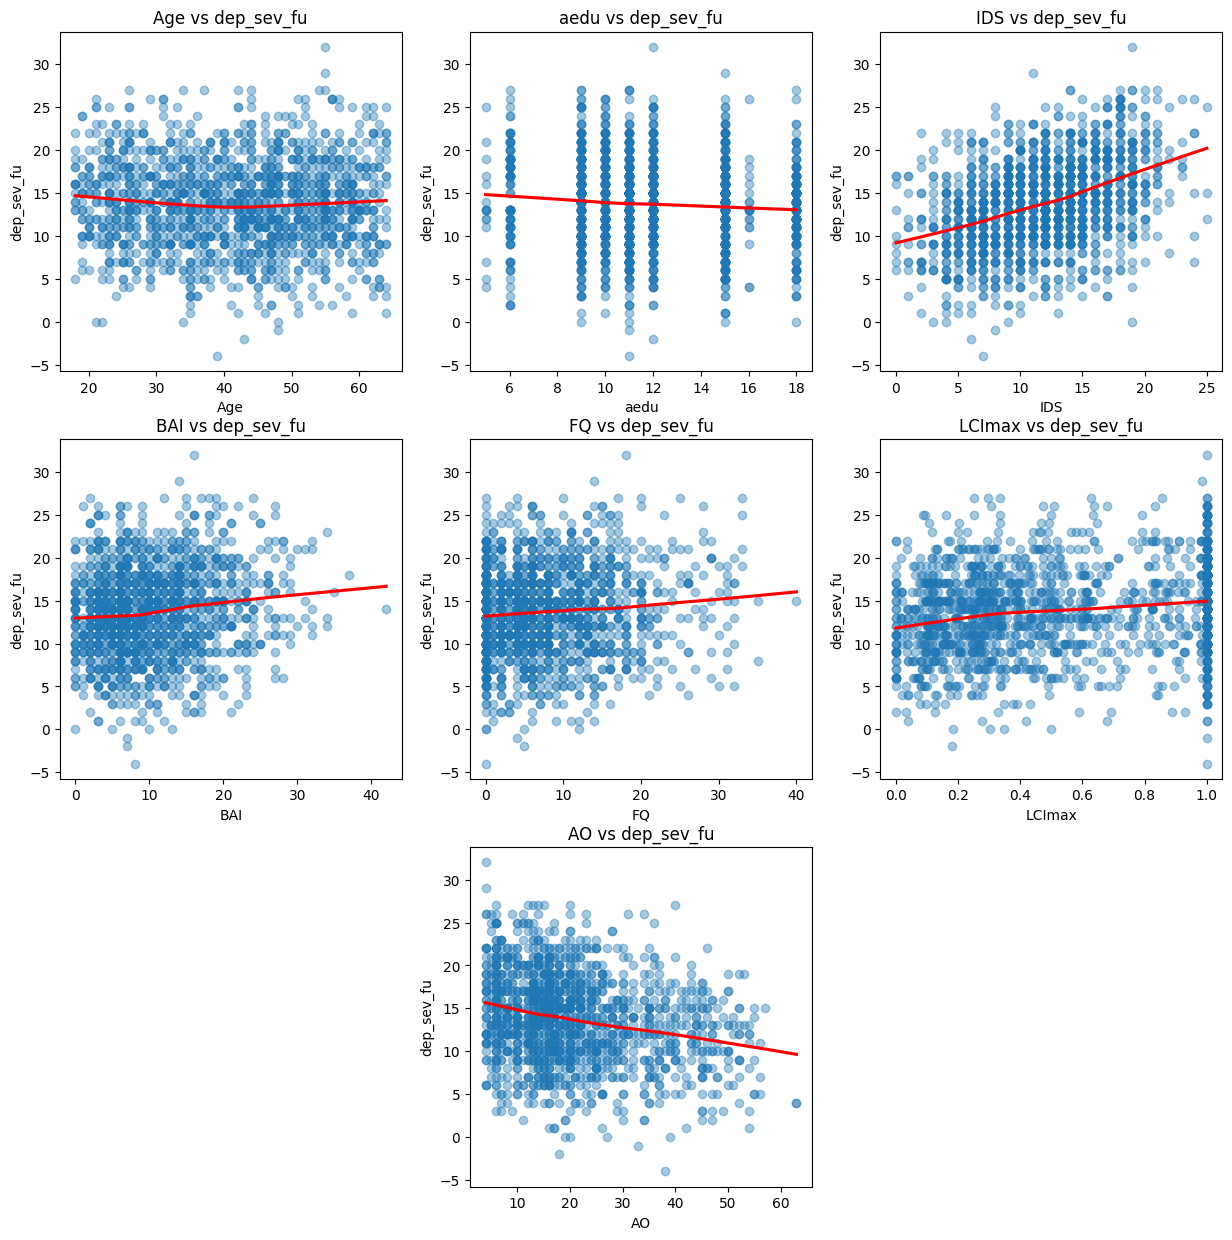

In [5]:
X = data.drop(columns=['dep_sev_fu'])
y = data['dep_sev_fu']

numeric_cols = ['Age', 'aedu', 'IDS', 'BAI', 'FQ', 'LCImax', 'AO']

fig, axes = plt.subplots(3, 3, figsize=(15, 5*3))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    if i < 6:
        ax = axes[i]
    else:
        ax = axes[7]
    sns.regplot(x=X[col], y=y, lowess=True, ax=ax, scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
    ax.set_xlabel(col)
    ax.set_ylabel('dep_sev_fu')
    ax.set_title(f'{col} vs dep_sev_fu')
fig.delaxes(axes[6])
fig.delaxes(axes[8])
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=4645251)
print(f'Training set size: {len(y_train)}')
print(f'Test set size: {len(y_test)}')

Training set size: 1000
Test set size: 500


In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
residuals = y_test - y_pred

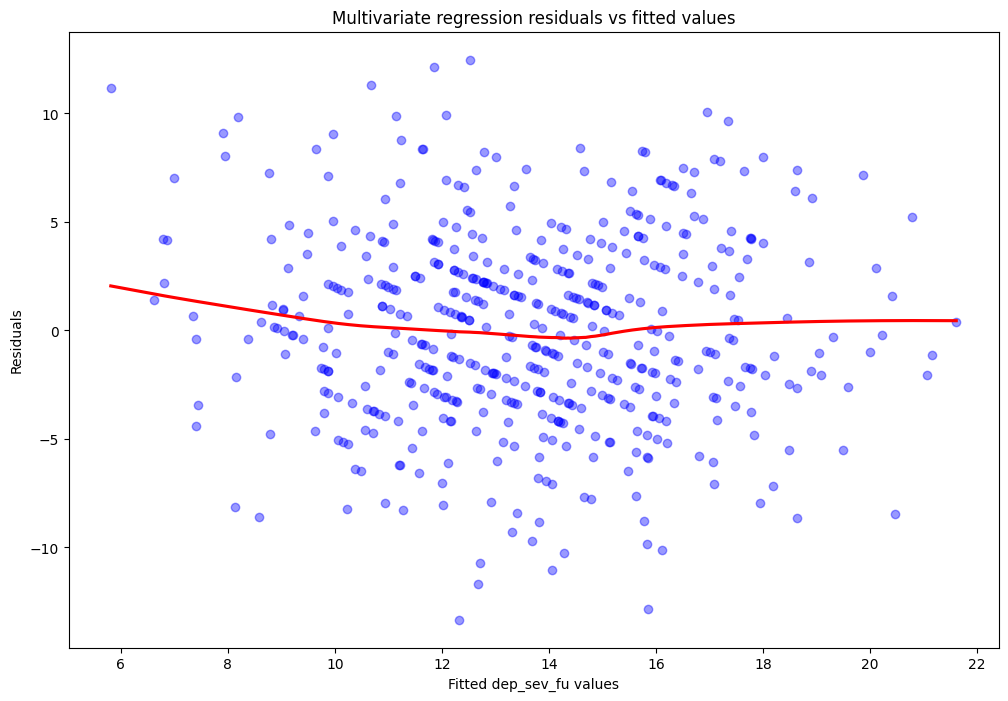

In [8]:
plt.figure(figsize=(12,8))
sns.regplot(x=y_pred, y=residuals, lowess=True, scatter_kws={'alpha': 0.4, 'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Fitted dep_sev_fu values')
plt.ylabel('Residuals')
plt.title('Multivariate regression residuals vs fitted values')
plt.show()

The lowess curve is mostly flat. We notice a slight trend appearing on the left end of the plot, though this may be due to the lack of data points in that region.
Although this cloud of points looks mostly random, we notice many parallel and evenly-spaced lines, which hint at the strong influence of one of our discrete (most likely numerical) independent variable relative to the others, perhaps ```IDS```, where each of these lines corresponds to a different value of that discrete variable. Nevertheless, this does not affect our diagnostic of the global relationship between our independent variables and the outcome, which looks roughly linear.

The main conclusion we draw from this preliminary data analysis is that a support vector machine with a linear kernel will most likely give a good fit, and there is no need for a more complicated model (e.g. with a non-linear kernel).

In [9]:
cost = [.001, .005, .0075, .01, .025, .05, .1, .5, 1]
epsilon = [.001, .005, .0075, .01, .025, .05, .1, .5, 1]

pipeline = make_pipeline(StandardScaler(), LinearSVR())

param_grid = {
    'linearsvr__C': cost
    , 'linearsvr__epsilon': epsilon
}

grid_search = GridSearchCV(
    pipeline
    , param_grid
    , scoring='neg_mean_squared_error'
    , cv=10
    , n_jobs=-1
    , verbose=1
)

grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)
print('Best CV MSE:', '{:.3e}'.format(-grid_search.best_score_))

y_pred = grid_search.predict(X_test)
test_mse = round(mean_squared_error(y_true=y_test, y_pred=y_pred), 3)
print('Test MSE with best parameters:', '{:.3e}'.format(test_mse))

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters: {'linearsvr__C': 1, 'linearsvr__epsilon': 0.1}
Best CV MSE: 1.982e+01
Test MSE with best parameters: 2.042e+01


In [10]:
best_model = grid_search.best_estimator_
svr = best_model.named_steps['linearsvr']

In [11]:
table_data = zip(X.columns, svr.coef_.round(3))
table = tabulate(table_data, headers=['Predictor', 'SVR coefficient'], tablefmt='grid')
# print(table)
df_svr = pd.DataFrame({'predictor': X.columns, 'SVR_coef': svr.coef_.round(3)})
df_svr.sort_values(by='SVR_coef', ascending=False, inplace=True)
df_svr
df_svr.to_csv('svr_coefs.csv')

In [12]:
df_svr.to_csv('svr_coefs.csv')

In [13]:
table_data = [
    ['Ridge regression', 'λ = 7.947e-02', '1.977e+01']
    , ['Linear SVR', 'C=1, ε=0.1', '2.041e+01']
    , ['Polynomial regression', '/', '2.054e+01']
]

table = tabulate(table_data, headers=['Model', 'Best hyperparameter(s)', 'Test MSE'], tablefmt='grid')
print(table)

+-----------------------+--------------------------+------------+
| Model                 | Best hyperparameter(s)   |   Test MSE |
+=======================+==========================+============+
| Ridge regression      | λ = 7.947e-02            |      19.77 |
+-----------------------+--------------------------+------------+
| Linear SVR            | C=1, ε=0.1               |      20.41 |
+-----------------------+--------------------------+------------+
| Polynomial regression | /                        |      20.54 |
+-----------------------+--------------------------+------------+


In [14]:
df_patient = pd.read_csv('Patient.csv')
# convert bool cols:
bool_cols = df_patient.select_dtypes(include='bool').columns
df_patient[bool_cols] = df_patient[bool_cols].astype(int)
# convert string to factor:
cat_cols = df.select_dtypes(include='O').columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(df[cat_cols])
encoded_patient = encoder.transform(df_patient[cat_cols])
new_df_patient = pd.concat([pd.DataFrame(encoded_patient, columns=encoder.get_feature_names_out(cat_cols)), df_patient.drop(columns=cat_cols)], axis=1)
# exclude level 0 factor columns:
new_df_patient = new_df_patient.reindex(columns=X.columns)
new_df_patient.head()
# triple bam!

,Age,aedu,IDS,BAI,FQ,LCImax,AO,RemDis,ADuse,PsychTreat,...,alcohol_No positive alcohol diagnose,bTypeDep_First onset MDD,bTypeDep_No depressive disorder,bTypeDep_Recurrent MDD,bSocPhob_Positive,bGAD_Positive,bPanic_Positive,bAgo_Positive,sample_Primary care,sample_Specialised mental health care
0,59,11,18,16,8,0.684211,4,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
y_pred_david = grid_search.predict(new_df_patient)
print('Predicted depressive symptom severity for David:', round(y_pred_david[0], 2))

Predicted depressive symptom severity for David: 16.81


# Part B

In [16]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [17]:
data_B = pd.read_csv('data.US.csv', index_col=0)
data_B.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31
1,1.605614,1.327888,0.500417,0.532226,0.089706,1.768943,-0.122878,1.027719,0.655933,1.130489,...,-1.725234,-1.456562,-1.269639,-2.694366,-1.273796,0.055670,-0.567091,-1.036103,-0.930181,-0.301975
2,-1.704421,-1.020374,-0.443030,-0.053948,-1.057264,-0.344164,-0.656811,-0.964902,-1.554952,0.493367,...,-0.654164,-0.098401,2.087344,-0.849739,-0.107819,0.271540,0.678361,-0.387106,0.041716,1.354849
3,0.364832,0.183848,-0.168000,1.435019,-0.238336,0.941176,0.658639,-1.165146,-0.547225,-0.014966,...,1.078867,2.112119,1.091892,-0.091432,-0.465045,-0.835906,0.646085,1.569557,0.104572,0.322749
4,-0.851385,0.060076,-0.217220,-0.381867,-0.531341,-0.299548,-2.672061,-1.742971,-1.781468,-1.694932,...,-2.715633,-0.153253,0.422856,-1.669791,0.285274,2.285014,-0.528509,-0.879869,1.544707,0.389038
5,0.197561,1.258870,-0.036793,0.818857,-0.317831,0.425909,-1.029285,-0.717234,-0.129079,-0.491869,...,-2.952420,-0.843833,-0.055026,-2.416975,-0.438478,0.634956,0.012462,-1.321352,-0.466044,-0.246619


In [18]:
data_B.dtypes.unique()

array([dtype('float64')], dtype=object)

In [19]:
data_B.shape

(1000, 30)

Only floats. Thank you!!

In [20]:
pca = PCA()
pca.fit(data_B)

PCA()

In [21]:
pca.components_.shape

(30, 30)

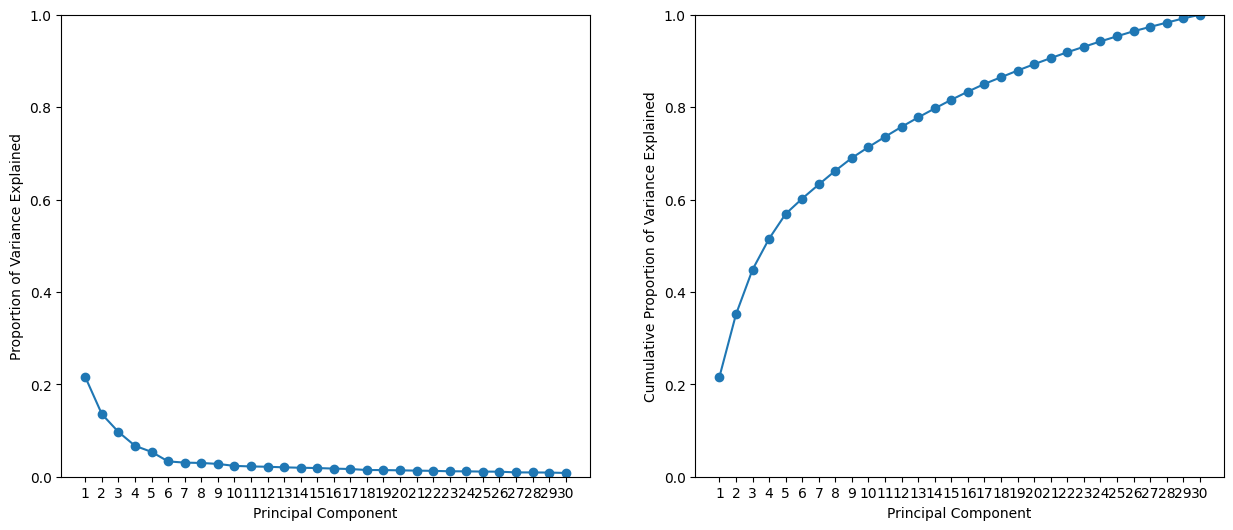

In [22]:
pve_ratios = pca.explained_variance_ratio_

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ticks = np.arange(pca.n_components_) + 1
ax = axes[0]
ax.plot(ticks, pve_ratios, marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks);

ax = axes[1]
ax.plot(ticks, pve_ratios.cumsum(), marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks);

In [23]:
pca.explained_variance_[:10].round(3)

array([6.472, 4.065, 2.908, 2.009, 1.612, 0.995, 0.916, 0.893, 0.833,
       0.703])

Horn's parallel analysis was done in R studio.

## Clustering

In [24]:
from sklearn.cluster import KMeans

In [25]:
scores = pca.transform(data_B)
top_PC = scores[:, :5]

In [26]:
top_PC.shape

(1000, 5)

Ok. We're going to fit KMeans on our top 5 components, not the original data.

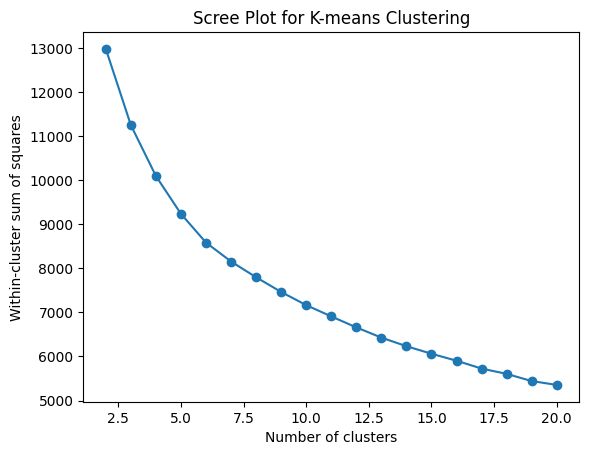

In [27]:
wcss = []  # within cluster sum of squares
k_vals = range(2, 21)

for k in k_vals:
    kmeans = KMeans(n_clusters=k, random_state=4645251, n_init=80).fit(top_PC)
    wcss.append(kmeans.inertia_)

plt.plot(k_vals, wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Scree Plot for K-means Clustering')
plt.show()

In [41]:
loadings = pd.DataFrame(
    pca.components_.T[:, :2].round(3)
    , columns=[f'PC{i+1}' for i in range(2)]
    , index=data_B.columns
)
loadings.to_csv('loadings.csv')

IndexError: index 25 is out of bounds for axis 0 with size 25

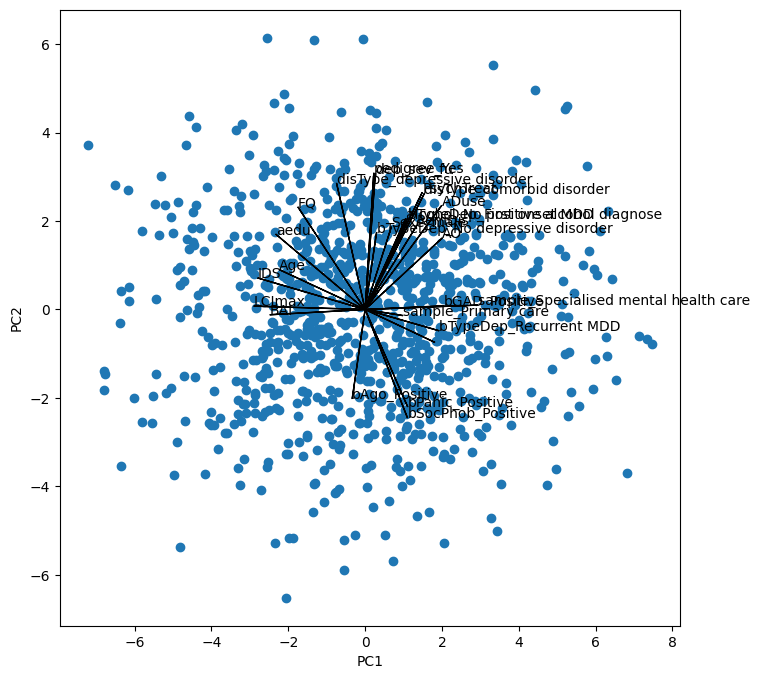

In [39]:
scale_arrow = s_ = 10
scores[:, 1] *= -1
pca.components_[1] *= -1
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[0, k], s_*pca.components_[1, k])
    ax.text(s_*pca.components_[0, k], s_*pca.components_[1, k], data.columns[k])